# Fitting a Line Using MCMC
By Griffin Hosseinzadeh (2019 April 17)  
Updated by Charlotte Mason (2020 August 28)  
Updated by Griffin Hosseinzadeh (2025 April 30)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 150

import emcee
import corner

## Generate Some Fake Data
Choose a slope $m$, intercept $b$, and scatter $\sigma$, and generate $N$ random points using the `np.random` module. Plot the results to see what your data look like. Our goal is to recover the parameters defined here. (Hint: this section is identical to the previous notebook.)

<ErrorbarContainer object of 3 artists>

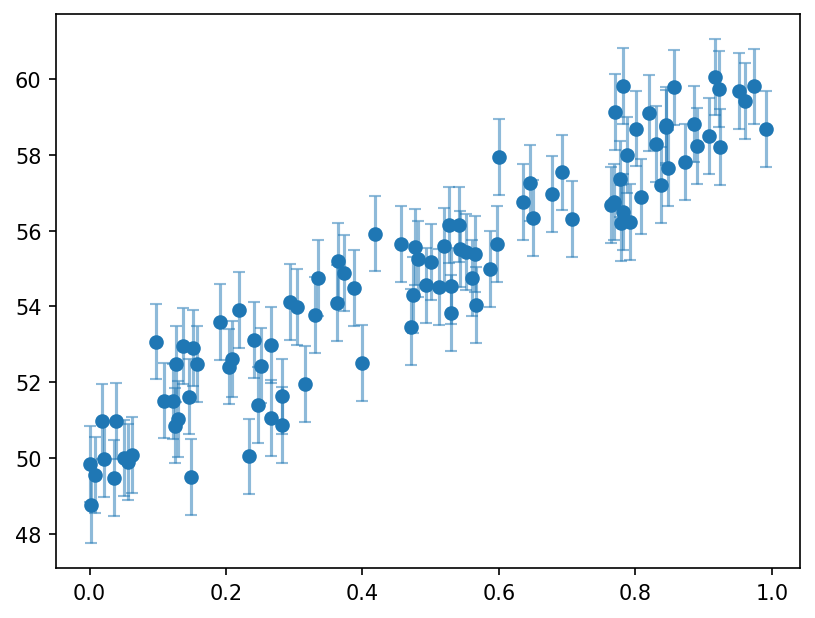

In [2]:
m = 10.
b = 50.
dy = 1.
N = 100
rng = np.random.default_rng(1234567890)

x = np.sort(rng.uniform(0, 1, N))
y = m*x + b + rng.normal(0, dy, N)
plt.scatter(x, y)
plt.errorbar(x, y, dy, ls='', capsize=3, alpha=0.5)

## Write Down the Posterior
Define functions that return the prior, the likelihood, and the posterior given a parameter vector `theta = [m, b]`. For computational accuracy (and convenience), we actually want to do this in log space. You can either use `np.log` (natural log) or `np.log10` (base-10 log). Regardless of the shape of your prior, it's good practice to limit the values of $m$ and $b$ to some reasonable range. (Hint: this section is identical to the previous notebook.)

In [3]:
m_min = 0.
m_max = 100.
b_min = 0.
b_max = 100.

def log_prior(theta: list[float, float]):
    """
    Returns log(prior) for a given parameter vector
    
    Parameters
    ----------
    theta: list[float, float]
        List of parameters in the form [slope, intercept]
    
    Returns
    -------
    ln_prior: float
        Natural log of the prior probability function
    """
    m, b = theta

    log_m = 0
    b_val = 0

    if m_min < m < m_max:
        log_m = np.log(m)
    if b_min < b < b_max:
        b_val = 1
    
    return log_m * b_val

def log_likelihood(theta, x, y, dy):
    """
    Returns log(likelihood) for a given set of parameters

    Parameters
    ----------
    theta: list[float, float]
        List of parameters in the form [slope, intercept]
    x: array[float]
        x-value of data
    y: array[float]
        y-value of data
    dy: array[float] or float
        uncertainty of data

    Returns
    -------
    ln_likelihood: float
        Natural log of the likelihood function 
    """
    m, b = theta
    model = m*x + b
    likelihood_scalar = np.log(2*np.pi*(dy**2))
    likelihood_exp = ((y - model) / dy) ** 2

    ln_likelihood = -(1/2) * (likelihood_scalar + likelihood_exp)

    return ln_likelihood.sum()



def log_posterior(theta, x, y, dy):
    """
    Returns the posterior of a set of values (unscaled).
    
    Parameters
    ----------
    theta: list[float, float]
        List of parameters in the form [slope, intercept]
    x: array[float]
        x-value of data
    y: array[float]
        y-value of data
    dy: array[float] or float
        uncertainty of data
    
    Returns
    -------
    ln_posterior: float
        Natural log of the posterior function
    """
    ln_prior = log_prior(theta)
    ln_likelihood = log_likelihood(theta, x, y, dy)
    
    ln_posterior = ln_prior + ln_likelihood
    return ln_posterior

## Set Up the Ensemble Sampler
This time we will use the `emcee` package that you imported above to sample the posterior probability distribution. Everything you need is contained within the `emcee.EnsembleSampler` class. Initialize this with 100 walkers and the `log_posterior` function you defined above. Don't forget that `log_posterior` takes additional arguments `x`, `y`, and `dy`. (Hint: check the documentation for `EnsembleSampler` for how to deal with this.)

Note, we will initialise the sampler in #1.5

In [4]:
n_walkers = 100
n_params = 2
args = [x, y, dy]

## Setup random initial guesses for the starting positions

You'll need to give initial guesses for each walker, which you can draw randomly from the prior. 

In [5]:
# guess values: 20, 60
# guess width: 10
m_random = np.random.normal(20, 10, size=n_walkers)
b_random = np.random.normal(60, 10, size=n_walkers)
initial_guesses =np.array([[m_random[i], b_random[i]] for i in range(n_walkers)])

## Initialize and run!

Initialize the `EnsembleSampler` object and then run it with the `run_mcmc` method. For now, 10000 steps is more than enough, and should run in less than a minute on your laptop. If this command takes too long, ask for help.

In [6]:
# initialize the sampler
sampler = emcee.EnsembleSampler(n_walkers, n_params, log_posterior, args = args)

# run!
sampler.run_mcmc(initial_state=initial_guesses, nsteps=int(1e4))

State([[ 9.47541688 50.20776442]
 [10.21711101 49.76711443]
 [ 9.75230867 50.25541485]
 [10.01303143 50.12301444]
 [ 9.9620997  49.90564302]
 [ 9.85354567 49.90234361]
 [ 9.84476821 49.9641595 ]
 [ 9.73512657 49.99341513]
 [ 9.5985325  50.13718405]
 [ 9.85762077 50.02872561]
 [ 9.44428956 50.22445132]
 [ 9.16467721 50.27024501]
 [ 9.69309626 50.29735853]
 [ 9.41108981 50.2074785 ]
 [10.00237342 49.98942017]
 [ 8.97323248 50.32546732]
 [ 9.51412842 50.17383741]
 [10.26272868 49.94286838]
 [ 9.91888596 50.04953826]
 [ 9.86374911 50.12957762]
 [10.01188327 49.9911599 ]
 [ 9.9407277  49.89910386]
 [ 9.34266784 50.36783592]
 [ 9.5738952  50.19284435]
 [ 9.84428321 49.98000913]
 [10.15945486 49.93016279]
 [ 9.73478693 50.10598399]
 [ 9.46535319 50.33218267]
 [10.02488976 50.16042341]
 [ 9.43274162 50.08828044]
 [ 9.64427282 50.16628231]
 [ 9.12519256 50.39751715]
 [ 9.259517   50.30665049]
 [ 9.78792909 50.29524928]
 [ 9.20168549 50.25896589]
 [ 9.9640937  49.99068999]
 [ 9.62072309 50.08618

## Plot the Results
First make a plot of the walker positions (value of each parameter) at each step. Write a function to do this, since you'll be using it a lot.

(100, 10000, 2)


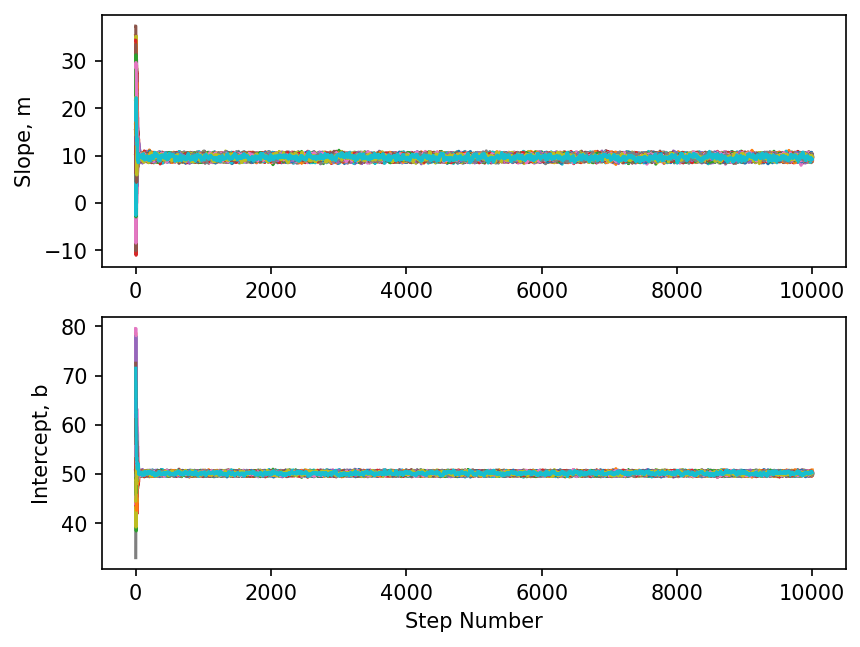

In [7]:
print(sampler.chain.shape)  # check that this has dimensions (n_walkers, n_steps, n_params)

def chain_plots(chain: np.ndarray, **kwargs):
    """
    Plot the histories for each walker in sampler.chain
    
    Parameters
    ----------
    chain: ndarray
        3D array given by sampler.flatchain, with shape (n_walkers, n_steps, n_params)
    kwargs: `.Line2D` properties, optional
        All keyword arguments are passed to `pyplot.plot`
    """
    start = 0
    if 'start_idx' in kwargs.keys():
        start = kwargs.pop('start_idx')

    chain = chain.swapaxes(0, 1)
    fig, ax = plt.subplots(2)
    ax[0].plot(chain[start:,:,0], **kwargs)
    ax[0].set_ylabel('Slope, m')

    ax[1].plot(chain[start:,:,1], **kwargs)  # complete
    ax[1].set_xlabel('Step Number')
    ax[1].set_ylabel('Intercept, b')
    
chain_plots(sampler.chain)

Each one of those colored lines is a walker. They started out at your initial guesses. What do you immediately notice?

Try making more useful plots by zooming in on the relevant parts. Hint: you can adjust line opacity in matplotlib with the `alpha` parameter.

*The initial guesses are very far off, but quickly converge towards the correct answer.*

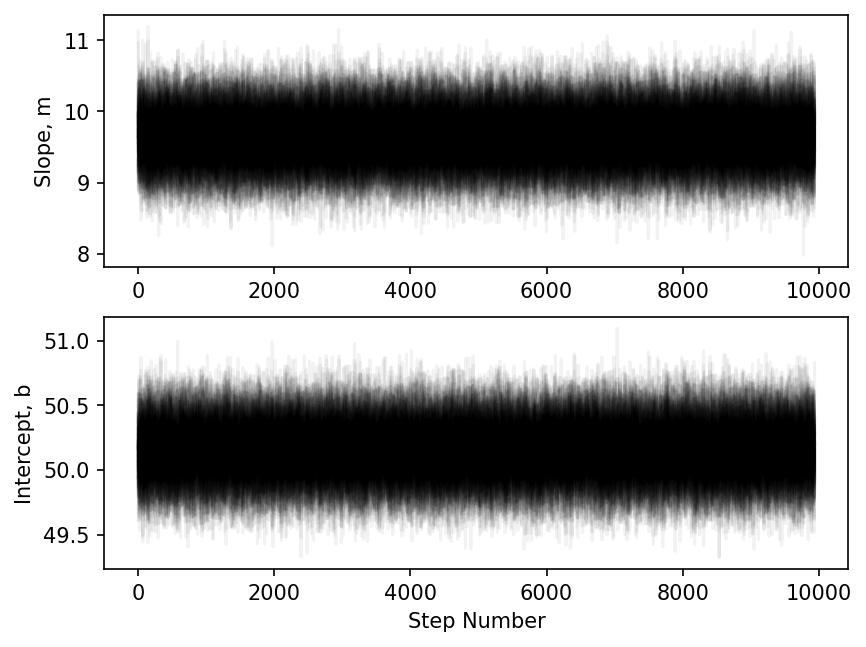

In [8]:
n_burn = 60
chain_plots(sampler.chain, start_idx=n_burn, alpha=0.05, c='black')

Are your chains converged? How many steps did it take for this to happen? This is called the "burn-in" period. **From now on, only use the steps after the burn-in period.**

Now make a scatter plot of the two parameters, one point for each walker-step. Hint: `sampler.flatchain`.

*They seem to have converged within about 50-60 steps.*

Text(0, 0.5, 'b')

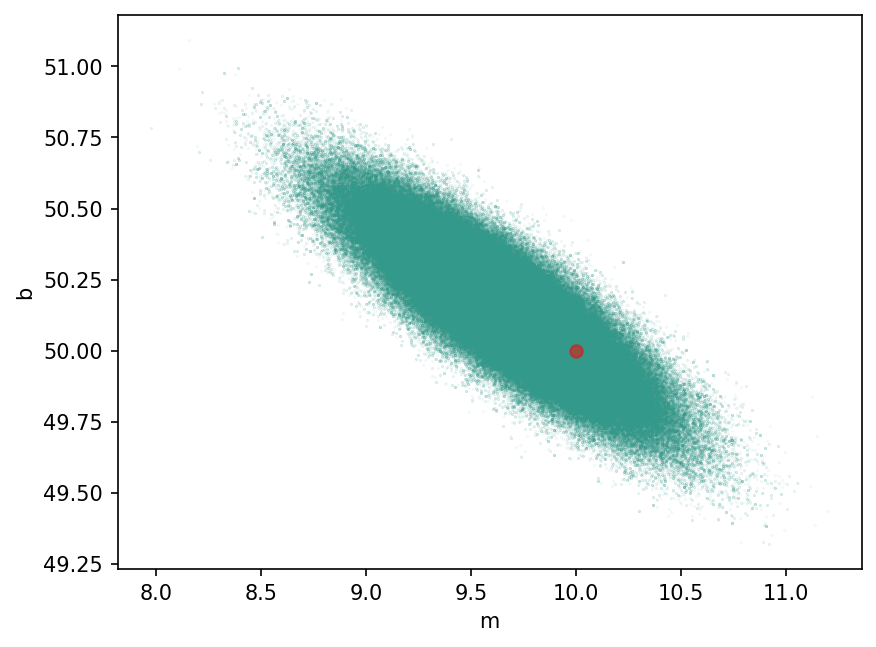

In [9]:
fig, ax = plt.subplots()
flattened_steps = n_burn * n_walkers
burnt_flatchain = sampler.flatchain[flattened_steps:]
m_values, b_values = burnt_flatchain.swapaxes(0,1)
ax.scatter(m_values, b_values, s=0.1, c="#33998a", alpha=0.1)
ax.scatter(10, 50, c='r', marker='o', alpha=0.5)
ax.set_xlabel("m")
ax.set_ylabel("b")

How does this compare to the distribution you had in the previous notebook (assuming you used the same parameters)?

Now let's marginalize over each parameter. Given that we have walkers that are distributed according to the 2D posterior, think about how to calculate the marginalized posterior for each parameter.

*This looks quite similar, although I believe the one from `monte_carlo_line_fitting.ipynb` was slightly more centered.*

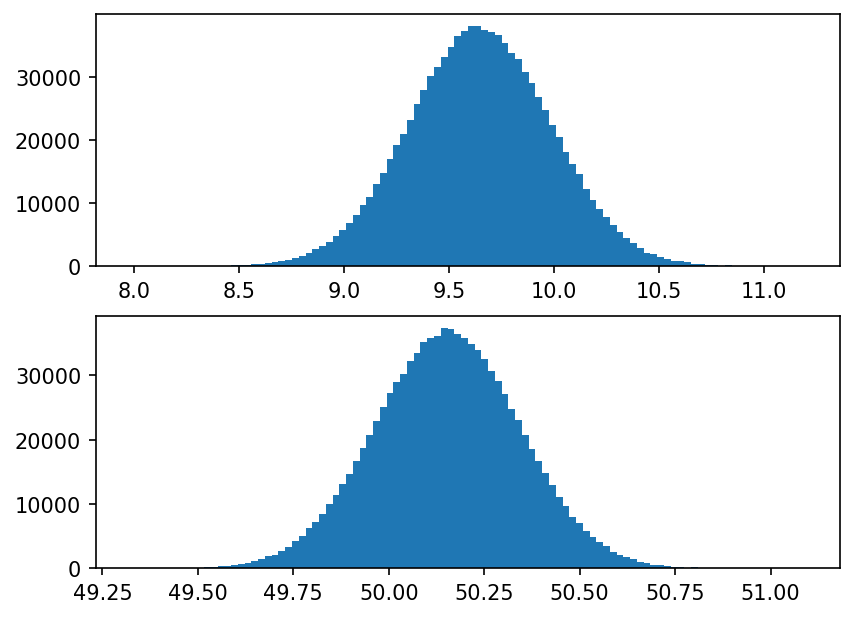

In [10]:
fig, ax = plt.subplots(2)
ax[0].hist(m_values, bins=100)
ax[1].hist(b_values, bins=100)
plt.show()

Calculate the medians and the 68% ($1\sigma$) confidence intervals for each parameter. Check your answers against the centers and widths of the distributions you just plotted above. Do they look about right?

In [11]:
m_med = np.median(m_values)
m_mean = np.mean(m_values)
m_std_dev = np.std(m_values)
dm_lo =  - m_std_dev
dm_hi =  + m_std_dev

b_med = np.median(b_values)
b_mean = np.mean(b_values)
b_std_dev = np.std(b_values)
db_lo =  - b_std_dev
db_hi =  + b_std_dev

print(f'$m = {m_med:.2f}_{{{dm_lo:+.2f}}}^{{{dm_hi:+.2f}}}$')

print(f'$b = {b_med:.2f}_{{{db_lo:+.2f}}}^{{{db_hi:+.2f}}}$')

$m = 9.65_{-0.34}^{+0.34}$
$b = 50.15_{-0.19}^{+0.19}$


There's an easy way to generate all these plots and summary statistics: `corner.corner`! Produce a corner plot with the true parameters labeled and the best-fit values (with error bars) printed on the plot. How close did we get to the parameters we used to generate the data?

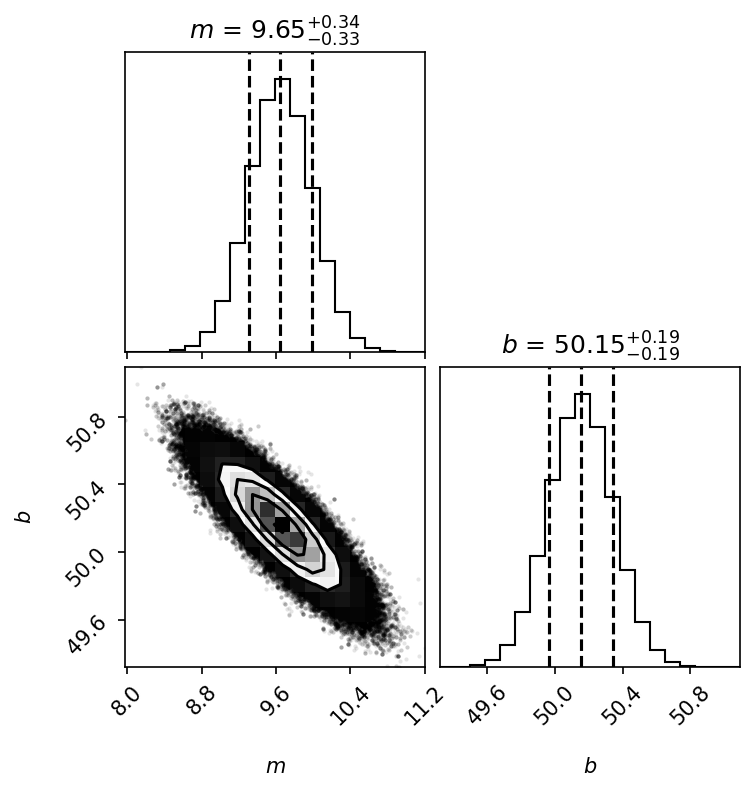

In [12]:
corner = corner.corner(burnt_flatchain,
              labels=[r'$m$', r'$b$'],
              quantiles = [0.5-0.68/2, 0.5, 0.5+0.68/2],
              show_titles=True)

*The true value of b is within the 68% confidence interval, but the true value we got of m was just 0.01 outside of the confidence interval. I think that letting the chain go on longer may have helped, but I'm not sure.*

## Take-Away Message
MCMC is a much more efficient way to sample the probability distribution because the walkers mostly stay in the highest-probability region. Plus it essentially gives you the marginalized posteriors for free, because the density of walkers matches the probability density.

## Other Things to Try
- Add a parameter for the intrinsic scatter and redo the MCMC fit.
- Try implementing Metropolis-Hastings algorithm yourself and see if you can get the same results as `emcee`.